# Algoritmos Genéticos

El objetivo de esta práctica es estudiar el funcionamiento de los algoritmos heurísticos no constructivos poblacionales. Este tipo de algoritmos parten de un conjunto de solución iniciales para a través de operaciones de transformación ir mejorando las soluciones candidatas. Los algoritmos que estudiar son algoritmos genéticos: básico, multimodal y CHC. Deberán compararse con los resultados de la búsqueda local del mejor vecino de la práctica 1.

Se deberá ejecutar con al menos 3 semillas. Se admitirá modificar los criterios de parada para que la ejecución del algoritmo no supere 5 minutos de ejecución por semilla en la experimentación.

## Librerías

In [1]:
import random
import math
import copy
import numpy as np

# Graphs and Plots
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

import statistics

import pandas as pd

import os

## Parámetros

### Semillas

In [2]:
# Establecer semillas

semilla_1 = 9244889
semilla_2 = 6885052
semilla_3 = 1689685
semilla_4 = 2674794
semilla_5 = 3656827

semillas = [semilla_1, semilla_2, semilla_3, semilla_4, semilla_5]

### Precio

Precio de compra y precio de venta forman el array de 2 filas precio donde:
- precio[0] corresponde al precio_compra
- precio[1] corresponda al precio_venta

El precio se expresa en cents/kWh

In [3]:
# precio[0] = precios de compra
precio_compra_problema1 = [26, 26, 25, 24,23,24,25,27,30,29,34,32,31,31,25,24,25,26,34,36,39,40,38,29]
precio_compra_problema2= [7,7,50,25,11,26,48,45,10,14,42,14,42,22,40,34,21,31,29,34,11,37,8,50]

# precio[1] = precios de venta
precio_venta_problema1 = [24, 23, 22, 23,22,22,20,20,20,19,19,20,19,20,22,23,22,23,26,28,34,35,34,24] # 21 = max
precio_venta_problema2= [1,3,21,1,10,7,44,35,4,1,23,12,30,7,30,4,9,10,6,9,8,27,7,10]

precio_problema1 = [precio_compra_problema1, precio_venta_problema1]
precio_problema2 = [precio_compra_problema2, precio_venta_problema2]

precio = precio_problema1

### Radiacion
Radiacion en Wh/m2

In [4]:
# radiacion W/h en m2
radiacion_problema1 = [0, 0, 0, 0, 0, 0, 0, 0, 100, 313, 500, 661, 786, 419, 865, 230, 239, 715, 634, 468, 285, 96, 0, 0]
radiacion_problema2 = [274, 345, 605, 810, 252, 56, 964, 98, 77, 816, 68, 261, 841, 897, 75, 489, 833, 96, 117, 956, 970, 255, 74, 926]

radiacion = radiacion_problema1

### Horas

In [5]:
horas = [0] * 24
for idx, hora in enumerate(horas):
    horas[idx] = idx

### Constantes

In [6]:
superficie = 1000   # m2
ganancia = 0.2  # 20%
bateria_maxima = 300 # kw                           # * 1000     # kW * 1000 = W

#### Algoritmos

In [7]:
mejor_name = "El Mejor"
algoritmo_genetico_basico_name = "AG Básico"
algoritmo_genetico_CHC_name = "AG CHC"
algoritmo_genetico_multimodal_name = "AG MultiModal"

### Resultados

In [8]:
Data = []
Algorithms_names = []

El resultado esperado es la cantidad en euros conseguida en el día, calculada como el precio por kWh vendidos en esa Hora. Dado que lo que podamos vender dependerá de la carga de la batería en dicho momento no se puede saber de antemano el resultado, por lo que el resultado será calculado mediante una simulación usando los precios y radiación. La simulación interpretará las instrucciones en la solución actual a evaluar calculando cada hora la carga de la batería y la cantidad en euros, que puede ser negativa.

## Funciones auxiliares

### Conversiones de parametros

#### Energia

In [9]:
def kw_to_w(energia_kw):
    '''
    kwh a wh
    '''

    return energia_kw * 1000

def w_to_kw(energia_w):
    '''
    w a kw
    '''

    return energia_w / 1000

In [10]:
def energia_a_porcentaje(energia):
    """
    :param energia: energia en kW
    :return porcentaje_bateria: equivalente de esos kW en porcentaje de la bateria
    """

    porcentaje_bateria = (energia / bateria_maxima) * 100

    return porcentaje_bateria


def porcentaje_a_energia(porcentaje):
    """
    :param porcentaje: equivalente de esos kW en porcentaje de la bateria
    :return energia: energia en kW
    """

    energia = (porcentaje * bateria_maxima) / 100

    return energia

#### Dinero

In [11]:
def cents_to_euros(cents):
    '''
    cents to euros
    '''

    return cents / 100

def euros_to_cents(euros):
    '''
    euro to cents
    '''

    return euros * 100

### Representación gráfica

In [12]:
def representar_grafica(dinero_hora, bateria_hora, precios_venta = precio_venta_problema1, precios_compra = precio_compra_problema1, img_name = ""):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    dinero = host.twinx()
    bateria = host.twinx()

    offset = 5

    '''new_fixed_axis = dinero.get_grid_helper().new_fixed_axis
    dinero.axis["left"] = new_fixed_axis(loc="left", axes=dinero,
                                            offset=(0, 0))'''

    new_fixed_axis = bateria.get_grid_helper().new_fixed_axis
    bateria.axis["right"] = new_fixed_axis(loc="right", axes=bateria,
                                            offset=(offset, 0))

    host.set_xlabel("Horas")
    # host.set_ylabel("Dinero (€)")
    dinero.set_ylabel("Dinero (€)")
    bateria.set_ylabel("Bateria (%)")

    # host.set_xlim(0, 23)
    #host.set_ylim(0, 400)



    # bateria.set(ylim=(0,100))
    dinero.set(ylim=(min(dinero_hora),max(dinero_hora)))



    # Dinero acumulado en cada hora
    host.plot(horas,
             dinero_hora,
             linewidth=3,
             color='yellow',
             alpha=0.5)

    # Capacidad de la bateria en cada hora
    bat, = bateria.plot(horas,
             bateria_hora,
             color='green',
             alpha=0.8)

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_venta, #[p * coeficiente_representacion for p in precios_venta],
             color='blue')

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_compra, #[p * coeficiente_representacion for p in precios_venta],
             color='red')

    host.legend(["Dinero Acumulado",  "Precios de venta", "Precios de compra", "Batería"])

    bateria.axis["right"].label.set_color(bat.get_color())

    if img_name:
        plt.text(1, 13, round(dinero_hora[len(dinero_hora)-1], 2), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        plt.title(img_name)

        if not os.path.exists(img_name.split(" (")[0]):
            os.makedirs(img_name.split(" (")[0])

        plt.savefig(img_name.split(" (")[0] + "/" + img_name + ".png", dpi=300, bbox_inches='tight')

    plt.show()

    return plt

In [13]:
def representar_evolucion_algoritmo(totales_dinero, img_name = ""):
    # plt.figure(figsize=(20,5))
    plt.plot(range(0, len(totales_dinero)), totales_dinero, 'r')
    plt.xlabel('Ejecucion')
    plt.ylabel('Dinero (€)')

    if img_name:
        # plt.text(1, 13, round(max(totales_dinero), 2), style='italic', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
        plt.title(img_name)

        if not os.path.exists(img_name.split(" (")[0]):
            os.makedirs(img_name.split(" (")[0])

        plt.savefig(img_name.split(" (")[0] + "/" + img_name + "_evolucion_" + ".png", dpi=300, bbox_inches='tight')

    plt.show()

### Otras

In [14]:
def flatten(l):
    return [item for sublist in l for item in sublist]

Los valores que queremos obtener son:
Evaluaciones = numero medio de evaluaciones realizada por el algoritmo en las cinco ejecuciones
- Evaluación media (tiempo)
- Evaluación mejor (tiempo)
- Evaluación Desviación (tiempo)
- Mejor €
- Media €
- Desviación €

## Funciones auxiliares comunes a los algoritmos

### Generar Solución Inicial

In [15]:
def solucion_aleatoria():
    # implementación de la generación de solución inicial
    solucion = [0] * 24 # Inicializar el vector con 24 ceros

    # Generar una solución válida
    for hora in range(0,24):

        numero_aleatorio = random.randint(-100,100) # Generar un num aleatorio entre el -100 y 100

        assert -100 <= numero_aleatorio <= 100, "Un numero no está en los limites"

        solucion[hora] = numero_aleatorio

    return solucion

def solucion_inicial():
    return solucion_aleatoria()

### Función Evaluación

In [16]:
def funcion_evaluacion(solucion, radiacion = radiacion, precio = precio, representar = False, img_name = ""):
    bateria_capacidad_porcentaje = 0
    dinero_total = 0

    hora_venta_pico = precio[1].index(max(precio[1]))

    # para la representacion de las funciones
    dinero_hora = [0 for _ in range(24)]
    bateria_hora = [0 for _ in range(24)]
    precios_venta = [0 for _ in range(24)]
    precios_compra = [0 for _ in range(24)]

    for hora in horas:

        # 1. Almacenar nueva energia
        energia_recibida = w_to_kw(radiacion[hora]) * superficie * ganancia  # a kwh
        bateria_capacidad_porcentaje += energia_a_porcentaje(energia_recibida)    # incrementar % de la bateria


        precio_venta_actual = precio[1][hora]
        precio_compra_actual = precio[0][hora]
        precios_venta[hora] = precio_venta_actual
        precios_compra[hora] = precio_compra_actual

        # 2. Vender si hay sobrante
        if bateria_capacidad_porcentaje > 100:
            porcentaje_bateria_sobrante = bateria_capacidad_porcentaje - 100
            bateria_capacidad_porcentaje = 100
            dinero_total += cents_to_euros((porcentaje_a_energia(porcentaje_bateria_sobrante)) * precio_venta_actual)

        # assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites"
        # assert -100 <= solucion[hora] <= 100, "Solucion hora fuera de los limites: " + str(solucion[hora])

        if solucion[hora] >= 0:  # Compra el porcentaje de batería introducido respecto a la fracción de almacenaje disponible, después de introducir la energía recibida en esa hora. Al hacer la compra sobre el porcentaje de energía almacenada tras añadir la nueva energía, solo se superará la capacidad de la batería con la nueva energía a almacenar, en este caso, esa energía sobrante se venderá.

            # 3. Comprar energia
            bateria_almacenable_porcentaje = 100 - bateria_capacidad_porcentaje # todo no puese ser menor de 0
            bateria_almacenar_porcentaje = (solucion[hora]) * bateria_almacenable_porcentaje / 100
            bateria_capacidad_porcentaje += bateria_almacenar_porcentaje

            if bateria_capacidad_porcentaje > 100:
                bateria_capacidad_porcentaje = round(bateria_capacidad_porcentaje)
                if bateria_capacidad_porcentaje > 100:
                    bateria_capacidad_porcentaje = 100

            assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites al comprar: " + str(bateria_capacidad_porcentaje)

            dinero_total -= cents_to_euros(porcentaje_a_energia(bateria_almacenar_porcentaje) * precio_compra_actual)

        else: # Vende el porcentaje de energía almacenada introducido.
            # 3. Vende energia

            bateria_vender_porcentaje = (abs(solucion[hora]) * bateria_capacidad_porcentaje) / 100

            bateria_capacidad_porcentaje -= bateria_vender_porcentaje

            if bateria_capacidad_porcentaje < 0: # pasa con numeros decimales muy pequeños por el redondeo
                bateria_capacidad_porcentaje = round(bateria_capacidad_porcentaje)

            assert 0 <= bateria_capacidad_porcentaje <= 100, "Batería fuera de los posibles limites, al vender: " + str(bateria_capacidad_porcentaje)

            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_vender_porcentaje)) * precio_venta_actual)

        # si es la ultima hora vender todo:
        if hora == (len(horas) - 1):
            bateria_vender_porcentaje = 100 * bateria_capacidad_porcentaje / 100

            bateria_capacidad_porcentaje -= bateria_vender_porcentaje

            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_vender_porcentaje)) * precio_venta_actual)

            assert int(bateria_capacidad_porcentaje) == 0, "La batería no se ha vaciado completamente al terminar el día: " + str(bateria_capacidad_porcentaje)

        bateria_hora[hora] = bateria_capacidad_porcentaje
        dinero_hora[hora] = dinero_total

    if representar:
        representar_grafica(dinero_hora, bateria_hora, precios_venta, precios_compra, img_name)

    return dinero_total

### Movimiento

In [17]:
# se genera un numero de vecinos, por ej 40 -> elegir una posicion y hacer + / - granularidad de esa posicion, yendo de 1 en 1 o de 10 en 10
# Función para generar vecino
def generador_vecino(solucion_actual, n_vecinos = 1, granularidad = 10):
    # implementación de la generación de vecino
    vecinos = []

    for _ in [n_vecinos]:

        vecino = solucion_actual.copy()

        # incremento
        for idx, elemento in enumerate(range(len(vecino))):
            nuevo_vecino = vecino.copy()
            nuevo_valor = vecino[idx] + granularidad

            if not(-100 <= nuevo_valor <= 100):
                if nuevo_valor <= -100:
                    nuevo_valor = -100
                elif 100 <= nuevo_valor:
                    nuevo_valor = 100

            nuevo_vecino[idx] = nuevo_valor

            # Se comprueba que el número resultante esté dentro del rango [-100, 100]
            # vecino[idx] = max(min(vecino[idx], 100), -100)

            #Para evitar que pueda haber valores por encima de 100 (porque es suma), si es +100 -> no appendiza el valor
            if -100 <= nuevo_vecino[idx] <= 100:
                vecinos.append(nuevo_vecino)
                assert -100 <= nuevo_vecino[idx] <= 100, "Vecino fuera de los limites: " + str(nuevo_vecino[idx])

        # decremento
        for idx, elemento in enumerate(range(len(vecino))):
            nuevo_vecino = vecino.copy()
            nuevo_valor = vecino[idx] - granularidad
            nuevo_vecino[idx] = nuevo_valor

            # Se comprueba que el número resultante esté dentro del rango [-100, 100]
            # vecino[idx] = max(min(vecino[idx], 100), -100)
            # vecinos.append(vecino)

            #Para evitar que pueda haber valores por debajo de -100 (porque es resta), si es -100 -> no appendiza el valor
            if nuevo_vecino[idx] >= -100:
                vecinos.append(nuevo_vecino)
                assert -100 <= nuevo_vecino[idx] <= 100, "Vecino fuera de los limites: " + str(nuevo_vecino[idx])

        # vecinos.append(vecino)

    return vecinos

### Función auxiliar de evaluación

In [18]:
def evaluar_algoritmo(algorithm_name, parametros = []):
    Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor Dinero", "Ev. Medias Mejor"]

    Ev = []
    Dinero = []

    Data = []

    for semilla in semillas:
        random.seed(semilla)

        sol_inicial = solucion_inicial()

        if algorithm_name == mejor_name:
            solucion, contador_evaluaciones, totales_dineros = busqueda_local_mejor(max_evaluaciones=parametros[0], solucion_inicial=sol_inicial, granularidad = parametros[1])

            img_name = str(algorithm_name + " (" + str(parametros[0]) + " max. eval.) (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)

        elif algorithm_name == algoritmo_genetico_basico_name:
            # n_individuos, max_iteraciones, porcentaje_torneo
            solucion, contador_evaluaciones, totales_dineros = algoritmo_genetico_basico(n_individuos=parametros[0], max_iteraciones=parametros[1], max_iteraciones_sin_mejora=parametros[2], porcentaje_torneo=parametros[3])

            img_name = str(algorithm_name + " (Individuos " + str(parametros[0]) + ") (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)


        elif algorithm_name == algoritmo_genetico_CHC_name:
            # n_individuos, max_iteraciones, porcentaje_torneo
            solucion, contador_evaluaciones, totales_dineros = algoritmo_genetico_chc(n_individuos=parametros[0], max_iteraciones=parametros[1], tamano_nuevo=parametros[2], distancia_maxima=parametros[3])

            img_name = str(algorithm_name + " (Individuos " + str(parametros[0]) + ") (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)


        elif algorithm_name == algoritmo_genetico_multimodal_name:
            # n_individuos, max_iteraciones, porcentaje_torneo
            solucion, contador_evaluaciones, totales_dineros = algoritmo_genetico_multimodal(n_individuos=parametros[0], max_iteraciones=parametros[1], max_iteraciones_sin_mejora=parametros[2], porcentaje_torneo=parametros[3], n_nichos=parametros[4], radio=parametros[5])

            img_name = str(algorithm_name + " (Individuos " + str(parametros[0]) + ") (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)

        else:
            solucion, contador_evaluaciones, totales_dineros = busqueda_local_mejor(max_evaluaciones=parametros[0], solucion_inicial=sol_inicial, granularidad = parametros[1])

            img_name = str(algorithm_name + " (" + str(parametros[0]) + " max. eval.) (Semilla " + str(semilla) + ")")
            representar_evolucion_algoritmo(totales_dineros, img_name=img_name)
            funcion_evaluacion(solucion, representar=True, img_name=img_name)



        # print("Dinero total: " + str(dinero_total))

        # print(contador_evaluaciones[0], len(totales_dineros))

        # assert contador_evaluaciones[0] == len(totales_dineros), "El número de evaluaciones (" + str(contador_evaluaciones[0]) + ") no coincide con el número de resultados (" + str(len(totales_dineros)) + ")"

        # Ev.
        Ev.append(contador_evaluaciones)
        # €
        Dinero.append(totales_dineros)

    # print(Ev)

    # Ev = flatten(Ev)
    Dinero_flat = flatten(Dinero)

    # inicio = 0
    # fin = inicio
    lista_idx_dinero_max = []
    lista_dinero_max = []

    for idx, semilla in enumerate(semillas):
        # inicio = fin
        # fin = fin + Ev[idx]

        dinero_iteracion_actual = Dinero[idx]

        idx_max_dinero_iteracion_actual = dinero_iteracion_actual.index(max(dinero_iteracion_actual))
        lista_dinero_max.append(max(dinero_iteracion_actual))
        lista_idx_dinero_max.append(idx_max_dinero_iteracion_actual)

    # print(Ev)
    # print(lista_dinero_max)


    # 0 Ev. Medias
    Data.append(statistics.median(Ev))
    #Data.append(contador_evaluaciones)

    # 1 "Ev. Mejor" -> mide la covergencia
    # Data.append(Dinero.index(max(Dinero)))
    Data.append(min(Ev))

    # 2 "Ev. Desviación" -> mide la robustez, a mayor cercania a 0 mayor robustez
    # Data.append(statistics.stdev(Ev))
    Data.append(statistics.stdev(Ev))

    # 3 "Mejor €"
    Data.append(max(Dinero_flat))

    # 4 "Media €"
    # Data.append(statistics.median(Dinero))
    Data.append(statistics.median(lista_dinero_max))

    # 5 "Desviación €"
    # Data.append(statistics.stdev(Dinero))
    Data.append(statistics.stdev(lista_dinero_max))

    # 6 "Ev. Mejor Dinero"
    # Data.append(Dinero.index(max(Dinero)))
    semilla_ev_dinero_max = lista_dinero_max.index(max(lista_dinero_max))
    Data.append(str(semilla_ev_dinero_max + 1) + ": " + str(lista_idx_dinero_max[semilla_ev_dinero_max]))

    # 7 Ev. Medias para encontrar mejor solucion
    Data.append(statistics.median(lista_idx_dinero_max))

    for idx, dat in enumerate(Data):
        if idx != 6: Data[idx] = round(dat,2)

    print(pd.DataFrame(Data, Header, [algorithm_name]))

    return Data

In [19]:
def mostrar_estudio_algoritmos(Data):
    Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor Dinero"]

    print(pd.DataFrame(Data, Header))

    return Data

## Algoritmos de Heurísticas Constructivas

Heurísticas Constructivas: Parten de una solución inicial vacía y van añadiéndole componentes hasta construir una solución.

Las heurísticas constructivas son más rápidas pero dan soluciones de peor calidad que la búsqueda local (BL).

Ambos son procesos de búsqueda efectuados sobre un espacio de soluciones al problema. En los métodos constructivos, el espacio es de soluciones parciales, mientras que en la BL es de soluciones completas (candidatas).

El espacio de búsqueda suele ser de un tamaño exponencial con respecto al tamaño del problema.

### El Mejor

Se implementará siguiendo el esquema de el primer mejor y el mejor vecino, según el Tema 1 de teoría.

Se partirá de una solución inicial aleatoria. Los algoritmos de búsqueda local tienen su propia condición de parada, pero adicionalmente, en prevención de tiempos excesivos en algún caso, se añadirá una condición de parada alternativa (OR) basada en el número de evaluaciones que esté realizando la búsqueda, es decir, el número de veces se llame al cálculo de la función de coste. Este valor para la Búsqueda Local será de 3000 llamadas a la función de coste.

Para el número de vecinos del primer mejor se pasará a la siguiente solución cuando se encuentre un vecino mejor mediante una operación de movimiento o se haya alcanzado el número máximo de intentos sin mejora.

Haz un estudio de granularidad del operador de movimiento (al menos tres valores) respecto a la calidad de la solución encontrada. Para ello deberá mostrar varios gráficos de mejor solución (total euros generados) en cada iteración para cada velocidad.

Sobre busqueda local primero mejor:

Los valores de los parámetros max_evaluaciones y max_intentos_sin_mejora deben ser razonables para el problema específico porque estos parámetros afectan la cantidad de tiempo y recursos necesarios para ejecutar el algoritmo de búsqueda local.

El parámetro max_evaluaciones establece el número máximo de evaluaciones de la función de evaluación permitidas. Si el valor es demasiado bajo, el algoritmo puede no ser capaz de encontrar una solución óptima o incluso una solución aceptable. Si el valor es demasiado alto, el algoritmo puede tardar demasiado tiempo en ejecutarse, lo que lo hace ineficiente.

El parámetro max_intentos_sin_mejora establece el número máximo de iteraciones permitidas sin que se produzca una mejora en la solución. Si el valor es demasiado bajo, el algoritmo puede detenerse prematuramente antes de encontrar una solución óptima o aceptable. Si el valor es demasiado alto, el algoritmo puede continuar ejecutándose durante mucho tiempo, lo que también lo hace ineficiente.

Por lo tanto, es importante ajustar estos parámetros según las características específicas del problema para encontrar un equilibrio entre la calidad de la solución y el tiempo y recursos necesarios para encontrarla.

Búsqueda Local del Mejor (…el mejor vecino del entorno)

A partir de la solución actual genera todo el entorno completo de ella y selecciona la mejor solución vecina.

A continuación, comprueba si esa mejor vecina de la solución actual es mejor que la propia solución actual, y:
- En caso afirmativo la sustituye y vuelve a iterar
- En caso de que no, el algoritmo finaliza.

In [20]:
def generar_mejor_vecino_mejor(solucion_actual, granularidad):
    contador_evaluaciones = 0

    vecinos = generador_vecino(solucion_actual, granularidad = granularidad)

    valor_solucion_actual = funcion_evaluacion(solucion_actual)
    contador_evaluaciones += 1

    valor_mejor_vecino = valor_solucion_actual
    mejor_vecino = solucion_actual

    for vecino in vecinos:
        valor_vecino = funcion_evaluacion(vecino)
        contador_evaluaciones += 1

        # Si el mejor vecino mejora la solución actual, se actualiza la solución actual
        if valor_vecino > valor_mejor_vecino:
            mejor_vecino = vecino
            valor_mejor_vecino = valor_vecino

    return mejor_vecino, valor_mejor_vecino, contador_evaluaciones

def condicion_de_parada_mejor(valor_mejor_vecino, valor_solucion_actual):
    if valor_mejor_vecino <= valor_solucion_actual:
        return True
    else:
        return False

def busqueda_local_mejor(solucion_inicial = solucion_inicial(), max_evaluaciones=3000, granularidad = 10):

    # Parametros de control
    totales_dinero = []
    contador_evaluaciones = 0

    # Generar solución inicial
    solucion_actual = solucion_inicial

    valor_solucion_actual = funcion_evaluacion(solucion_actual)
    contador_evaluaciones += 1

    totales_dinero.append(valor_solucion_actual)

    valor_mejor_vecino = valor_solucion_actual

    while (valor_mejor_vecino > valor_solucion_actual) or (contador_evaluaciones < max_evaluaciones): # and intentos_sin_mejora < max_intentos_sin_mejora: -> esto es para mej no de salida

        valor_mejor_vecino = valor_solucion_actual

        # Obtiene el mejor vecino del entorno
        vecino, valor_vecino, aux_contador = generar_mejor_vecino_mejor(solucion_actual, granularidad)
        contador_evaluaciones += aux_contador

        if valor_vecino > valor_solucion_actual:
            valor_solucion_actual = valor_vecino
            solucion_actual = vecino

        totales_dinero.append(valor_solucion_actual)

    return solucion_actual, contador_evaluaciones, totales_dinero

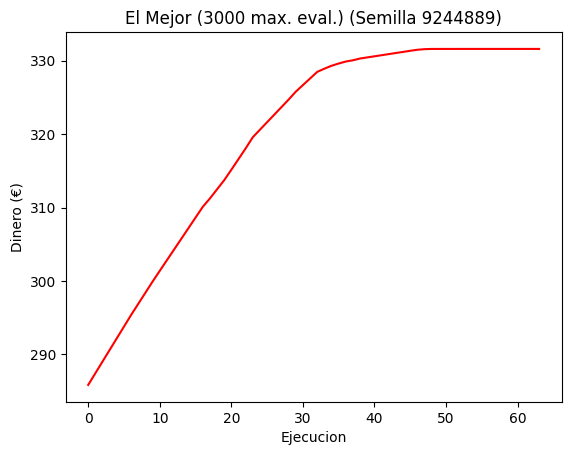

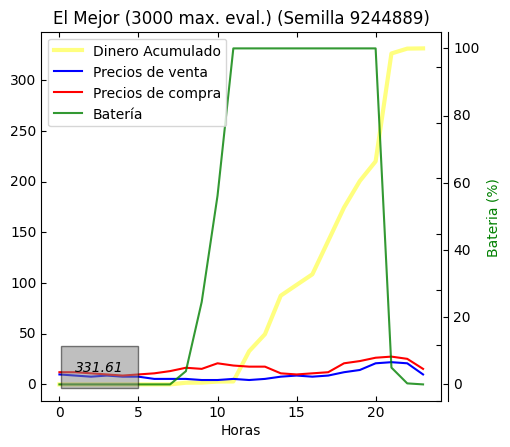

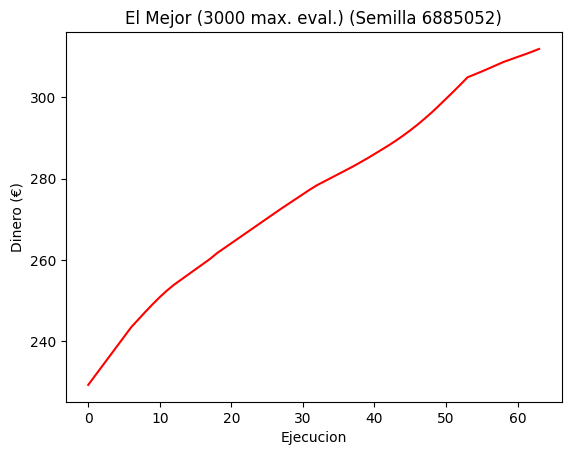

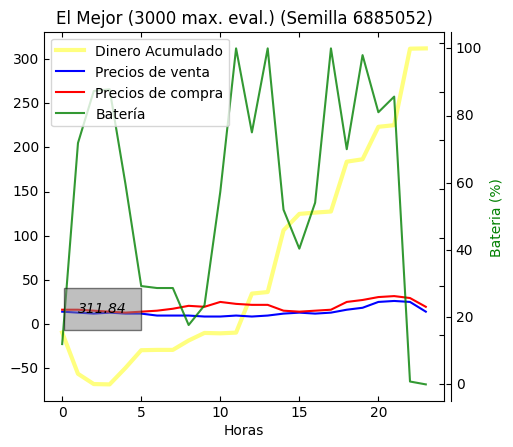

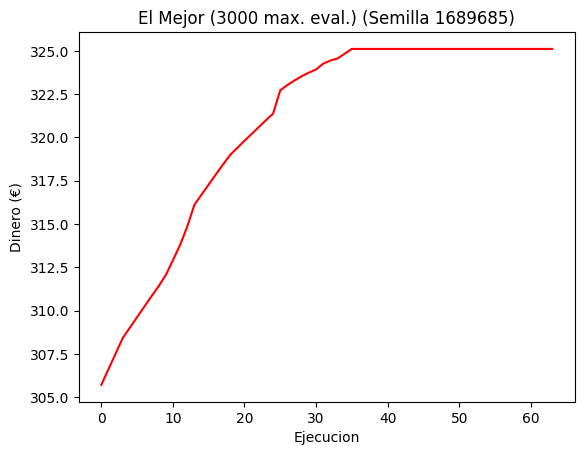

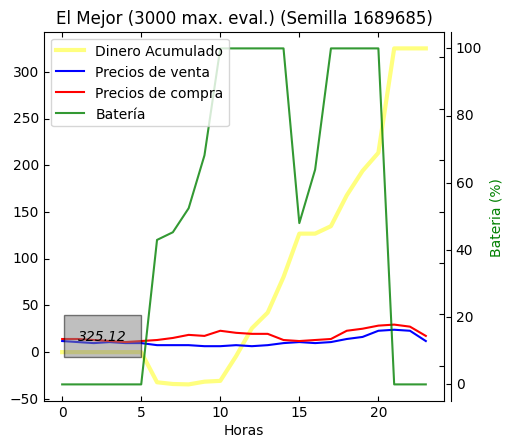

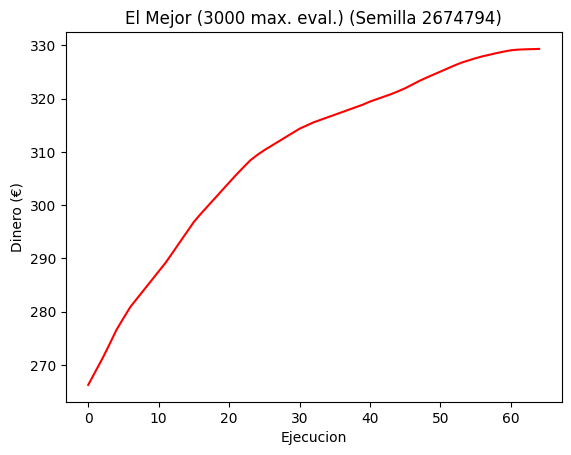

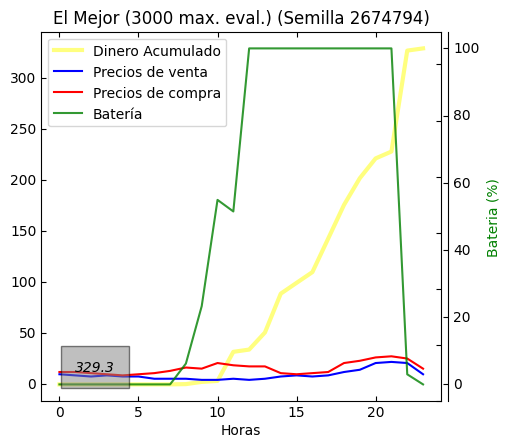

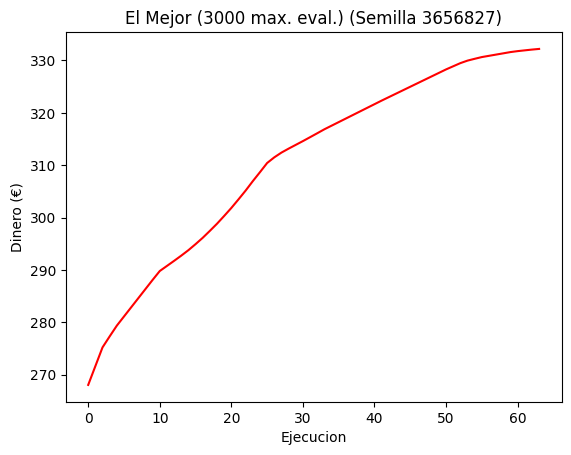

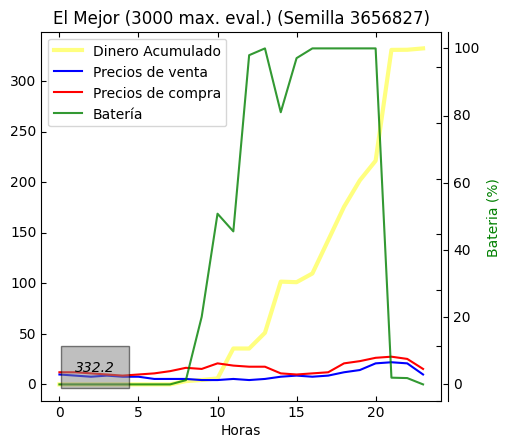

                 El Mejor
Ev. Medias           3025
Ev. Mejor            3013
Ev. Desviación        9.7
Mejor €             332.2
Media €             329.3
Desviación €          8.4
Ev. Mejor Dinero    5: 63
Ev. Medias Mejor       63


In [21]:
max_evaluaciones=3000
granularidad = 10

parametros = [max_evaluaciones, granularidad]

algorithm_name = mejor_name

Algorithms_names.append(algorithm_name)

'''mejor_data = evaluar_algoritmo(algorithm_name, parametros)
Data.append(mejor_data)'''

## Algoritmos de Hurísticas No Constructivas

### Funciones Comunes

In [22]:
# Función de inicialización de población
def inicializar_poblacion(n_individuos):
    poblacion = []
    for i in range(n_individuos):
        # Generar un individuo aleatorio
        individuo = solucion_inicial()
        poblacion.append(individuo)
    return poblacion

# Función de reemplazo: torneo
def torneo(poblacion, k):
    # Seleccionar k individuos al azar y elegir al mejor
    competidores = random.sample(poblacion, k)
    ganador = max(competidores, key=funcion_evaluacion)
    return ganador

# Operador de cruce: corte en dos puntos
def cruce(individuo1, individuo2):
    # Seleccionar dos puntos aleatorios de corte
    corte1 = random.randint(0, len(individuo1)-1)
    corte2 = random.randint(0, len(individuo1)-1)
    # Asegurar que corte2 > corte1
    if corte2 < corte1:
        corte1, corte2 = corte2, corte1
    # Generar dos hijos combinando las partes de los padres
    hijo1 = individuo1[:corte1] + individuo2[corte1:corte2] + individuo1[corte2:]
    hijo2 = individuo2[:corte1] + individuo1[corte1:corte2] + individuo2[corte2:]
    return hijo1, hijo2

### Algoritmo Genético Básico

In [29]:
# Algoritmo genético
def algoritmo_genetico_basico(n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo):
    # Inicializar parámetros de medición de rendimiento
    totales_soluciones = []
    contador_evaluaciones = 0
    # Inicializar población
    poblacion = inicializar_poblacion(n_individuos)
    # Evaluar la población inicial
    evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
    contador_evaluaciones += len(poblacion)
    # Encontrar el mejor individuo de la población inicial
    valor_mejor_individuo = max(evaluaciones)
    mejor_individuo = poblacion[evaluaciones.index(valor_mejor_individuo)]
    contador_evaluaciones += 1
    totales_soluciones.append(valor_mejor_individuo)
    # Inicializar contador de iteraciones sin mejora
    iter_sin_mejora = 0
    # Bucle principal del algoritmo
    for i in range(max_iteraciones):
        # Seleccionar dos padres y asegurar que k es minimo 3
        k = int(porcentaje_torneo * len(poblacion))
        if k<3:
            k = 3
        padre1 = torneo(poblacion, k)
        padre2 = torneo(poblacion, k)
        # Aplicar operador de cruce para obtener dos hijos
        hijo1, hijo2 = cruce(padre1, padre2)
        # Evaluar los hijos
        valor_hijo1 = funcion_evaluacion(hijo1)
        contador_evaluaciones += 1
        valor_hijo2 = funcion_evaluacion(hijo2)
        contador_evaluaciones += 1
        # Seleccionar el peor de los padres
        peor_padre = torneo([padre1, padre2], 2)
        valor_peor_padre = funcion_evaluacion(peor_padre)
        contador_evaluaciones += 1
        # Reemplazar el peor padre por el mejor hijo si lo mejora
        if valor_hijo1 > valor_hijo2:
            mejor_hijo = hijo1
        else:
            mejor_hijo = hijo2
        valor_mejor_hijo = funcion_evaluacion(mejor_hijo)
        contador_evaluaciones += 1
        if valor_mejor_hijo > valor_peor_padre:
            poblacion[poblacion.index(peor_padre)] = mejor_hijo
            # Actualizar mejor individuo
            if valor_mejor_hijo > valor_mejor_individuo:
                mejor_individuo = mejor_hijo
                valor_mejor_individuo = valor_mejor_hijo
                iter_sin_mejora = 0
            else:
                iter_sin_mejora += 1
        else:
            iter_sin_mejora += 1

        # Criterio de parada: si no hay mejora en el mejor individuo durante un número determinado de iteraciones
        if iter_sin_mejora >= max_iteraciones_sin_mejora:
            break

        totales_soluciones.append(valor_mejor_individuo)

    return mejor_individuo, contador_evaluaciones, totales_soluciones


In [30]:
n_individuos= 30
max_iteraciones = 2000
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.4

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo]

algorithm_name = algoritmo_genetico_basico_name

Algorithms_names.append(algorithm_name)

'''mejor_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(mejor_data)'''

'mejor_data = evaluar_algoritmo(algorithm_name, parametros)\n\nData.append(mejor_data)'

### Algoritmo Genético CHC

Aunque el algoritmo CHC fue concebido para cromosomas con codificación binaria, existen versiones para su uso con cromosomas con codificación en vector. El cálculo de la distancia de Hamming se realizará teniendo en cuenta cuantos genes difieren entre sí (cuantas posiciones difieren). Sólo aquellas cadenas con una distancia (mayor del umbral) serán combinados. El umbral se inicializará a L/4 siendo L la longitud de la cadena o cromosoma.

Cuando ningún descendiente es insertado en la nueva población el umbral se reduce a 1. En la fase de recombinación no se aplica ningún proceso de mutación. En su lugar, cuando la población converge o el proceso de búsqueda deja de progresar adecuadamente (el umbral de cruce llega a 0 y no se generan nuevos descendientes), la población se reiniciará. El cromosoma que represente la mejor solución hasta ese momento se utilizará como patrón para generar la nueva población (copiándose), y el resto se inicializarán de forma aleatoria.

La población debe ser menor o igual a la elegida en el genético básico. En el arranque, los valores de un cromosoma corresponden al mejor individuo de la generación anterior, y el resto serán aleatorios.

Se pueden poner más copias del mejor individuo para acelerar el proceso de reinicio si este es muy lento tras la primera reinicialización.

Hay que utilizar uno de los siguientes cruces:
- Parent Centered
- BLX-Alfa

Los cruces en CHC se hacen cambiando exactamente la mitad de los elementos QUE SON DISTINTOS en ambos padres y luego aplicando Parent Centered (una mutación similar a la mutación del genético básico) o BLX-Alpha (que genera un valor para cada hijo aplicando el algoritmo descrito en los apuntes).

Deberá reiniciar a menos cuatro veces. Criterio de parada: un número de iteraciones determinado por el alumno según la evolución del fitness sin que el mejor individuo haya mejorado su valor.

In [25]:
# Función de distancia Hamming
def distancia_hamming(individuo1, individuo2):
    distancia = sum(1 for i in range(len(individuo1)) if individuo1[i] != individuo2[i])
    return distancia

# Función de selección
def seleccion_chc(poblacion, tamano_nuevo, distancia_maxima):
    nueva_poblacion = []
    while len(nueva_poblacion) < tamano_nuevo:
        # Seleccionar un individuo aleatorio de la población
        individuo = random.choice(poblacion)
        # Generar un individuo aleatorio que tenga una distancia máxima con el seleccionado
        individuo_nuevo = copy.deepcopy(individuo)
        while distancia_hamming(individuo_nuevo, individuo) < distancia_maxima:
            for i in range(len(individuo)):
                if random.random() < 0.5:
                    individuo_nuevo[i] = individuo[i]
                else:
                    individuo_nuevo[i] = 1 - individuo[i]
        # Añadir el nuevo individuo a la nueva población
        nueva_poblacion.append(individuo_nuevo)
    return nueva_poblacion

# Algoritmo genético CHC
def algoritmo_genetico_chc(n_individuos, max_iteraciones, tamano_nuevo, distancia_maxima):
    # Inicializar parámetros de medición de rendimiento
    totales_soluciones = []
    contador_evaluaciones = 0
    # Inicializar población
    poblacion = inicializar_poblacion(n_individuos)
    # Evaluar la población inicial
    evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
    contador_evaluaciones += len(poblacion)
    # Encontrar el mejor individuo de la población inicial
    valor_mejor_individuo = max(evaluaciones)
    mejor_individuo = poblacion[evaluaciones.index(valor_mejor_individuo)]
    contador_evaluaciones += 1
    totales_soluciones.append(valor_mejor_individuo)
    # Bucle principal del algoritmo
    for i in range(max_iteraciones):
        # Seleccionar una nueva población
        poblacion = seleccion_chc(poblacion, tamano_nuevo, distancia_maxima)
        # Evaluar la población
        evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
        contador_evaluaciones += len(poblacion)
        # Encontrar el mejor individuo de la población
        valor_mejor_individuo_iter = max(evaluaciones)
        mejor_individuo_iter = poblacion[evaluaciones.index(valor_mejor_individuo_iter)]
        contador_evaluaciones += 1
        # Actualizar el mejor individuo global si corresponde
        if valor_mejor_individuo_iter > valor_mejor_individuo:
            valor_mejor_individuo = valor_mejor_individuo_iter
            mejor_individuo = mejor_individuo_iter

        totales_soluciones.append(valor_mejor_individuo)
    return mejor_individuo, contador_evaluaciones, totales_soluciones

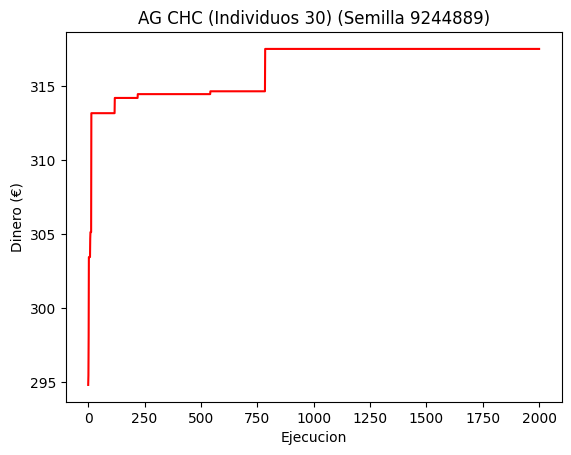

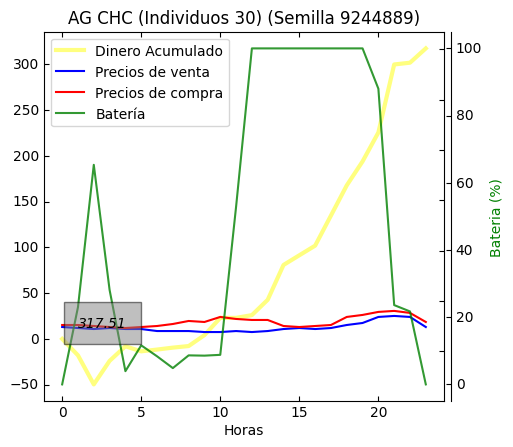

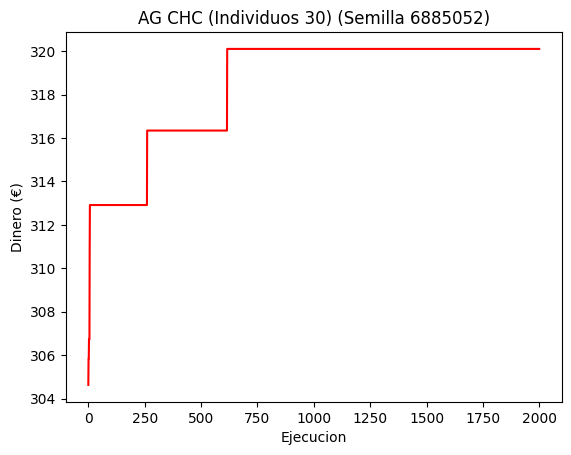

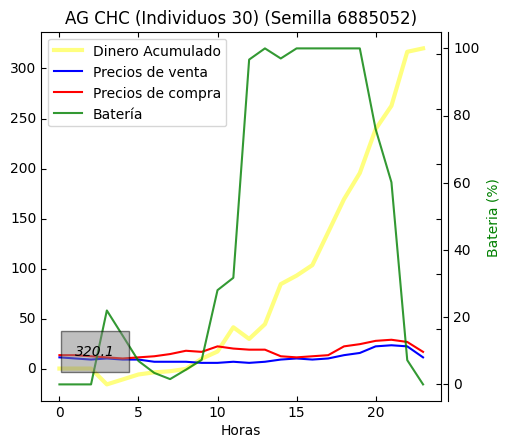

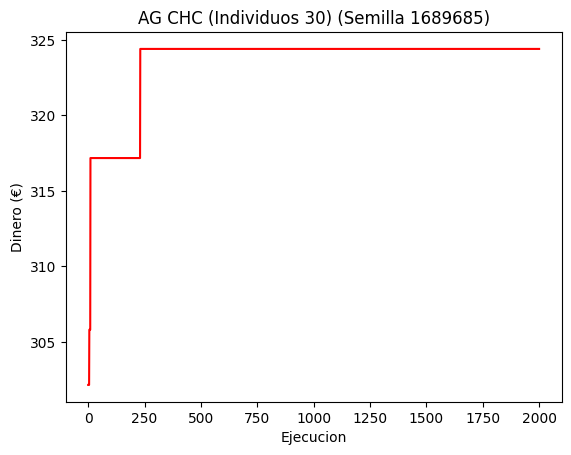

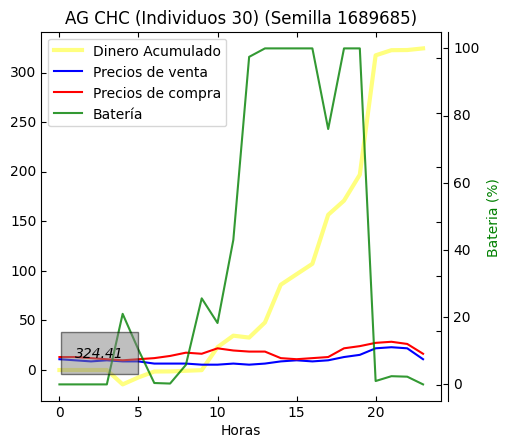

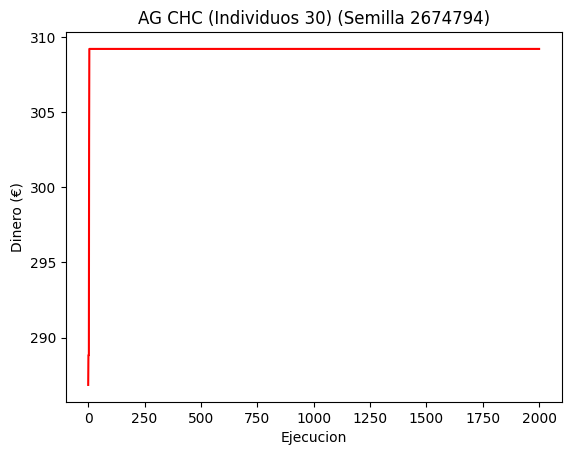

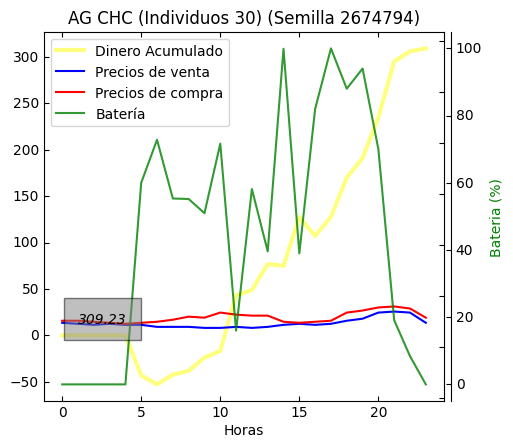

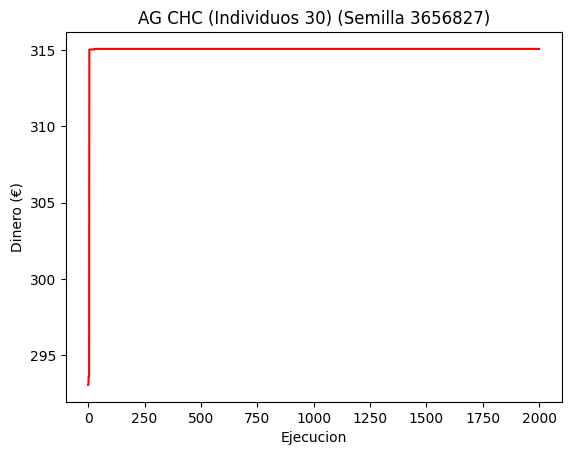

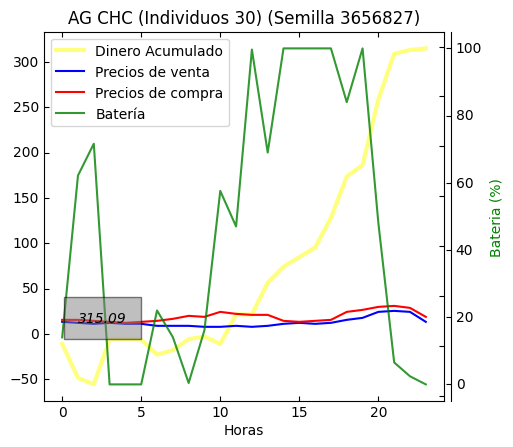

                  AG CHC
Ev. Medias         32031
Ev. Mejor          32031
Ev. Desviación       0.0
Mejor €           324.41
Media €           317.51
Desviación €        5.67
Ev. Mejor Dinero  3: 231
Ev. Medias Mejor     231


In [26]:
n_individuos= 30
max_iteraciones = 2000
tamano_nuevo = int(n_individuos/2)
distancia_maxima = 0.4

parametros = [n_individuos, max_iteraciones, tamano_nuevo, distancia_maxima]

algorithm_name = algoritmo_genetico_CHC_name

Algorithms_names.append(algorithm_name)

'''mejor_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(mejor_data)'''

### Algoritmo Genético Multimodal

Considerando como partida el AG Básico, debe implementar un AG multimodal espacial mediante el método de secuencial (5 nichos) o clearing, determinando un radio adecuado basado en la distancia de hamming.

- Donde d(i,j) es la distancia entre las soluciones.(distancia Hamming)
- Tamaño de la población menor o igual al genético básico.
- Probabilidad de cruce 0.8. (si no se cruza se copia como hijo )
- Mantener misma mutación que en el algoritmo básico.

El valor del radio tanto para el secuencial como para el clearing es crítico y debe ser propuesto por el alumno para que las soluciones finales sean suficientemente diferentes. Un radio muy pequeño no afectará casi nunca a los individuos al realizar el clearing o adaptar el fitness en el conjunto de soluciones y un valor muy alto hará que todos estén penalizados

En clearing es conveniente dejar un número de generaciones entre operaciones de aclarado, este parámetro denominado P, en el el generacional P iteraciones y en el estacionario p*Población/2 ya que una población equivalente se genera cada ese número de cruces. La kappa (numero de representantes de un nicho tiene que ser >= 2, para evitar que en un clearing quede sólo un elemento si los demás están en el mismo nicho y así poder generar el resto de los individuos hasta  rellenar la población cruzando los que hayan quedado del aclarado.

Método Secuencial estacionario

In [28]:
# Función de mutación: mutación por intercambio
def mutacion(individuo):
    # Seleccionar dos posiciones aleatorias del individuo e intercambiar sus valores
    pos1 = random.randint(0, len(individuo)-1)
    pos2 = random.randint(0, len(individuo)-1)
    individuo[pos1], individuo[pos2] = individuo[pos2], individuo[pos1]

# Función de reemplazo: nichos secuenciales
def nichos_secuenciales(poblacion, n_nichos, radio):
    nueva_poblacion = []
    # Crear una lista de nichos vacíos
    nichos = [[] for _ in range(n_nichos)]
    # Ordenar la población por valor de función de evaluación
    poblacion_ordenada = sorted(poblacion, key=lambda x: funcion_evaluacion(x), reverse=True)
    # poblacion_ordenada = sorted(poblacion, key=lambda x: evaluaciones[poblacion.index(x)], reverse=True)

    # Asignar cada individuo a un nicho
    for individuo in poblacion_ordenada:
        asignado = False
        for i, nicho in enumerate(nichos):
            if not asignado:
                # Comprobar si el individuo es cercano a algún individuo del nicho
                cercanos = [x for x in nicho if distancia_hamming(individuo, x) <= radio]
                if not cercanos:
                    # Si no hay cercanos, añadir el individuo al nicho
                    nichos[i].append(individuo)
                    asignado = True
        # Si no se asignó a ningún nicho, añadirlo a un nicho aleatorio
        if not asignado:
            nicho_aleatorio = random.choice(nichos)
            nicho_aleatorio.append(individuo)

    # Crear una nueva población con un individuo aleatorio de cada nicho
    for nicho in nichos:
        random.choice(nicho)
        if nicho:
            nueva_poblacion.append(random.choice(nicho))
        else:
            # Si el nicho está vacío, agregar un individuo aleatorio de la población original
            nueva_poblacion.append(random.choice(nicho_aleatorio))

    return nueva_poblacion

def nichos_clearing(individuos, tamano_nicho, clearing_radius):
    """
    Divide una lista de individuos en nichos de un tamaño dado y con un radio de clearing dado.

    Argumentos:
    individuos -- lista de individuos
    tamano_nicho -- tamaño de los nichos deseados
    clearing_radius -- distancia máxima permitida entre dos individuos en el mismo nicho

    Retorna:
    Una lista de listas de individuos.
    """

    # Inicializar la lista de nichos
    nichos = [[] for i in range(tamano_nicho)]

    # Iterar por cada individuo
    for individuo in individuos:
        asignado = False
        # Asignar el individuo a un nicho
        for i, nicho in enumerate(nichos):
            if not asignado:
                # Comprobar si el individuo es cercano a algún individuo del nicho
                cercanos = [x for x in nicho if distancia_hamming(individuo, x) <= clearing_radius]
                if not cercanos:
                    # Si no hay cercanos, añadir el individuo al nicho
                    nichos[i].append(individuo)
                    asignado = True
        # Si no se asignó a ningún nicho, añadirlo a un nicho aleatorio
        if not asignado:
            nicho_aleatorio = random.choice(nichos)
            nicho_aleatorio.append(individuo)

    return nichos

def reemplazo(poblacion, hijos, evaluaciones_poblacion, evaluaciones_hijos, n_individuos):
    # Combinar población y descendencia
    poblacion_completa = poblacion + list(hijos)
    evaluaciones_completas = evaluaciones_poblacion + evaluaciones_hijos
    # Ordenar población completa por evaluación (de mayor a menor)
    orden = sorted(range(len(evaluaciones_completas)), key=lambda k: evaluaciones_completas[k], reverse=True)
    poblacion_completa = [poblacion_completa[i] for i in orden]
    evaluaciones_completas = [evaluaciones_completas[i] for i in orden]
    # Seleccionar los mejores n_individuos de la población completa
    poblacion_nueva = poblacion_completa[:n_individuos]
    evaluaciones_nuevas = evaluaciones_completas[:n_individuos]
    # Devolver la nueva población y sus evaluaciones correspondientes
    return poblacion_nueva, evaluaciones_nuevas


# Algoritmo genético multimodal
def algoritmo_genetico_multimodal(n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nichos, radio):
    # Inicializar parámetros de medición de rendimiento
    totales_soluciones = []
    contador_evaluaciones = 0
    # Inicializar población
    poblacion = inicializar_poblacion(n_individuos)
    # Evaluar la población inicial
    evaluaciones = [funcion_evaluacion(individuo) for individuo in poblacion]
    contador_evaluaciones += len(poblacion)
    # Encontrar el mejor individuo de la población inicial
    valor_mejor_individuo = max(evaluaciones)
    mejor_individuo = poblacion[evaluaciones.index(valor_mejor_individuo)]
    # Inicializar variables para detección de convergencia
    iteraciones_sin_mejora = 0
    iteracion_actual = 0
    # Ejecutar el algoritmo hasta alcanzar el número máximo de iteraciones o de iteraciones sin mejora
    while iteracion_actual < max_iteraciones and iteraciones_sin_mejora < max_iteraciones_sin_mejora:
        # Realizar torneo para selección de padres
        k = int(porcentaje_torneo * len(poblacion))
        if k<3:
            k = 3
        padre1 = torneo(poblacion, k)
        padre2 = torneo(poblacion, k)
        # Realizar cruce de los padres seleccionados
        descendencia = cruce(padre1, padre2)
        # Realizar mutación sobre la descendencia
        for individuo in descendencia:
            mutacion(individuo)
        # Evaluar la descendencia mutada
        evaluaciones_descendencia = [funcion_evaluacion(individuo) for individuo in descendencia]
        contador_evaluaciones += len(descendencia)
        # Reemplazar individuos peores de la población con la descendencia mutada
        poblacion, evaluaciones = reemplazo(poblacion, descendencia, evaluaciones, evaluaciones_descendencia, n_individuos)
        # Realizar nichos para diversificar la población
        # poblacion = nichos_secuenciales(poblacion, n_nichos, radio)
        poblacion = nichos_clearing(poblacion, n_nichos, radio)
        contador_evaluaciones += len(poblacion)
        # Actualizar mejor individuo y variables de convergencia
        valor_mejor_individuo_nuevo = max(evaluaciones)
        if valor_mejor_individuo_nuevo > valor_mejor_individuo:
            valor_mejor_individuo = valor_mejor_individuo_nuevo
            mejor_individuo = poblacion[evaluaciones.index(valor_mejor_individuo)]
            iteraciones_sin_mejora = 0
        else:
            iteraciones_sin_mejora += 1
        iteracion_actual += 1
        totales_soluciones.append(valor_mejor_individuo)

    return mejor_individuo, contador_evaluaciones, totales_soluciones







n_individuos= 30
max_iteraciones = 2000
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.4
n_nicho = 5
radio = 30

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nicho, radio]

algorithm_name = algoritmo_genetico_multimodal_name

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

TypeError: '>=' not supported between instances of 'list' and 'int'

In [236]:
n_individuos= 30
max_iteraciones = 2000
max_iteraciones_sin_mejora = float("inf")
porcentaje_torneo = 0.4
n_nicho = 5
radio = 10

parametros = [n_individuos, max_iteraciones, max_iteraciones_sin_mejora, porcentaje_torneo, n_nicho, radio]

algorithm_name = algoritmo_genetico_multimodal_name

Algorithms_names.append(algorithm_name)

mejor_data = evaluar_algoritmo(algorithm_name, parametros)

Data.append(mejor_data)

IndexError: list index out of range

## Resultados Finales

In [74]:
Header = ["Ev. Medias", "Ev. Mejor", "Ev. Desviación", "Mejor €", "Media €", "Desviación €", "Ev. Mejor €", "Ev. Medias Mejor"]

# Algorithms_names.append(0)
# Data.append([0,0,0,0,0,0,0,0])

import numpy as np

Data_copy = np.array(Data)

# print(pd.DataFrame(Data.transpose(), Header, column))

# ev_media, ev_mejor, ev_desviacion, euro_mejor, euro_media, euro_desviacion = v

format_row = "{:>19}" * (len(Header) + 1)
print(format_row.format("", *Algorithms_names))
for dat, row in zip(Header, Data_copy.transpose()):
    print(format_row.format(dat, *row))

                                Greedy Búsqueda Aleatoria           El Mejor   Primero El Mejor Búsqueda Local VNDSimulated Annealing      Búsqueda Tabú                  0
         Ev. Medias                  1                101               3017               3027              47978              40000              36338                  0
          Ev. Mejor                  1                101               3009               3015              34183              40000              34911                  0
     Ev. Desviación                  0                0.0               9.91              11.33           10448.65                0.0             727.86                  0
            Mejor €            398.026             469.07             553.95             596.07             608.97             675.14             674.55                  0
            Media €            398.026             424.21             541.29             570.59             579.58             664.72       